In [50]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
data = fetch_olivetti_faces()

In [3]:
images = [np.repeat(data.images[i][:,:,np.newaxis],3,axis=2) for i in range(len(data.images))]

In [4]:
input_shape = images[0].shape
left_input = Input(input_shape)
right_input = Input(input_shape)

In [5]:
model = VGG19(include_top=False, weights='imagenet',input_shape=input_shape)
for layer in model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
x = model.output
x = Flatten()(x)
x = Dense(4096,activation='sigmoid')(x)

In [7]:
model_final = Model(input=model.input, output=x)

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [8]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [9]:
encoded_l = model_final(left_input)
encoded_r = model_final(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

siamese_net.compile(loss="binary_crossentropy",optimizer='adam')

In [10]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4096)         28417088    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           model_1[1][0]                    
          

In [11]:
classes = data.target

In [92]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, images, classes):
        self.data = images
        self.classes = np.unique(classes)
        self.class_image_id = dict(zip(self.classes,[np.argwhere(classes==i).reshape(1,-1)[0] for i in self.classes]))
        
    def get_batch(self,batch_size):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data
        n_examples = len(self.data)
        w, h, _  = input_shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(self.classes,size=(batch_size//2,2))
        categories = np.vstack([categories,np.repeat(rng.choice(self.classes,size=(batch_size//2,),replace=True)[:,np.newaxis],2,axis=1)])
        
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,3)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        for i in range(batch_size):
            category1, category2 = categories[i]
            idx_1 = rng.choice(self.class_image_id[category1])
            idx_2 = rng.choice(self.class_image_id[category2])
            pairs[0][i,:,:,:] = self.data[idx_1]
            pairs[1][i,:,:,:] = self.data[idx_2]
            if category1 == category2:
                targets[i] = 1
                
        return pairs, targets
    
    def generate(self, batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size)
            yield (pairs, targets)  

In [13]:
batch_size = 128
epochs = 10
steps_per_epoch = 100

In [45]:
train_count = 320
val_count = 40
test_count = len(images) - train_count - val_count

In [39]:
train_loader = Siamese_Loader(images[:train_count],classes[:train_count])
val_loader = Siamese_Loader(images[train_count:train_count+val_count],classes[train_count:train_count+val_count])

In [41]:
siamese_net.fit_generator(train_loader.generate(batch_size),steps_per_epoch=steps_per_epoch,epochs=epochs,validation_data=val_loader.generate(val_count),validation_steps=1)


Epoch 1/10
100/100 [==============================] - 566s 6s/step - loss: 0.1212 - val_loss: 0.8714
Epoch 2/10
100/100 [==============================] - 562s 6s/step - loss: 0.1159 - val_loss: 0.3829
Epoch 3/10
100/100 [==============================] - 555s 6s/step - loss: 0.1157 - val_loss: 0.6216
Epoch 4/10
100/100 [==============================] - 601s 6s/step - loss: 0.1094 - val_loss: 0.5458
Epoch 5/10
100/100 [==============================] - 1054s 11s/step - loss: 0.1001 - val_loss: 1.2111
Epoch 6/10
100/100 [==============================] - 550s 5s/step - loss: 0.0950 - val_loss: 0.8464
Epoch 7/10
100/100 [==============================] - 553s 6s/step - loss: 0.1006 - val_loss: 0.8739
Epoch 8/10
100/100 [==============================] - 949s 9s/step - loss: 0.0968 - val_loss: 0.7322
Epoch 9/10
100/100 [==============================] - 536s 5s/step - loss: 0.0956 - val_loss: 0.0286
Epoch 10/10
100/100 [==============================] - 1068s 11s/step - loss: 0.0934 - va

In [98]:
test_loader = Siamese_Loader(images[train_count+val_count:],classes[train_count+val_count:])
testX, testY = test_loader.get_batch(test_count)
testpred = siamese_net.predict(testX)
print ("Binary accuracy score is {}".format(accuracy_score(testY,testpred>.5)))

Binary accuracy score is 1.0


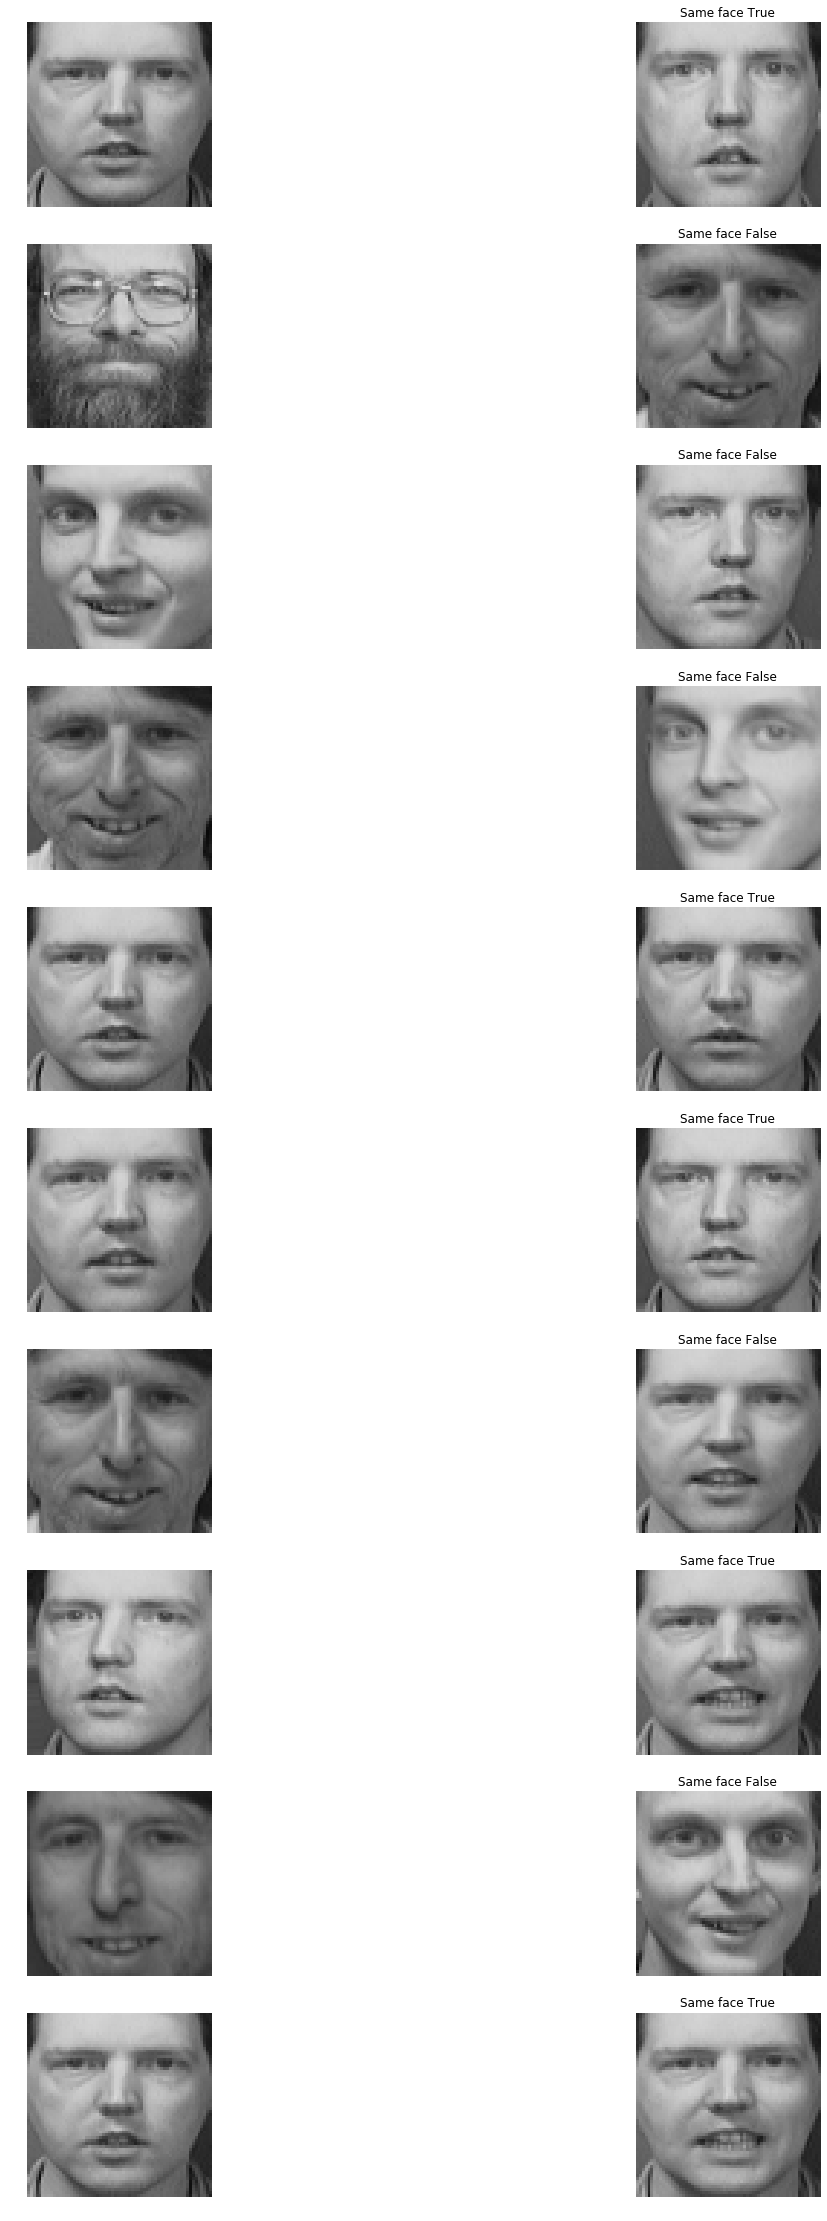

In [97]:
plt.figure(figsize=(20,40))
for row_num in range(10):
    sub = plt.subplot(10,2,row_num*2+1)
    sub.axis("off")
    sub.imshow(testX[0][row_num])
    
    sub = plt.subplot(10,2,row_num*2+2,title="Same face {}".format(testpred[row_num][0]>.5))
    sub.axis("off")
    sub.imshow(testX[1][row_num])        